# explore_stochmod
### Exploratory Visualization Script for Stochmod Output

In [100]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import xarray as xr
import time

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import matplotlib.ticker as mticker
from cartopy.util import add_cyclic_point

In [101]:
# Functions

def init_map(bbox):
    """
    Quickly initialize a map for plotting
    """
    # Create Figure/axes
    fig = plt.figure(figsize=(12,8)) 
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.set_extent(bbox)
    
    # Add Filled Coastline
    ax.add_feature(cfeature.COASTLINE,facecolor='k')
    
    # Add Gridlines
    gl = ax.gridlines(draw_labels=True,linewidth=0.5,color='gray',linestyle=':')
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    return fig,ax
    
def find_latlon(lonf,latf,lon,lat):
    """
    Find lat and lon indices
    """
    if((np.any(np.where(lon>180)) & (lonf < 0)) or (np.any(np.where(lon<0)) & (lonf > 180))):
        print("Potential mis-match detected between lonf and longitude coordinates")
    
    klon = np.abs(lon - lonf).argmin()
    klat = np.abs(lat - latf).argmin()
    
    msg1 = "Closest lon to %.2f was %.2f" % (lonf,lon[klon])
    msg2 = "Closest lat to %.2f was %.2f" % (latf,lat[klat])
    print(msg1)
    print(msg2)
    
    return klon,klat
    

def div_cint(var):
    """
    Automatically Set diverging colorbar based on min/max value
    """
    valmax = np.nanmax(var)
    valmin = np.nanmin(var)
    
    if np.abs(valmax) > np.abs (valmin):
        cint = np.linspace(-1*valmax,valmax,20)
    elif np.abs(valmax) < np.abs (valmin):
        cint = np.linspace(valmin,-1*valmin,20)
    
    return cint

In [102]:
# User Input Variables

# Set Point
lonf    = -30
latf    = 50

# Experiment Settings
entrain  = 1 # 0 = no entrain; 1 = entrain
hvarmode = 2 # 0 = fixed mld ; 1 = max mld; 2 = clim mld 
funiform = 2 # 0 = nonuniform; 1 = uniform; 2 = NAO-like

# Autocorrelation Parameters
kmon       = 2                 # Lag 0 base month
lags       = np.arange(0,61,1) # Number of lags to include
detrendopt = 0                 # Detrend before autocorrelation

# Bounding Box for visualization
lonW = -80
lonE = 20
latS = -20
latN = 90
bbox = [lonW,lonE,latS,latN]

# Paths
projpath = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/"
scriptpath = projpath + '03_Scripts/stochmod/'
datpath = projpath + '01_Data/'
outpath = projpath + '02_Figures/20200617/'


In [103]:
# Set some relevant strings for plotting
mons3=('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
monsfull=('January','Febuary','March','April','May','June','July','August','September','October','November','December')


# Lat Lon Strings
loc_figtitle = "Lon: %i Lat: %i" % (lonf,latf)
if lonf < 0:
    lonstr = lonf + 360
loc_fname    = "Lon%03d_Lat%03d"  % (lonstr,latf)

In [104]:
# Load Damping Data
damppath = '/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/01_hfdamping/01_Data/'
dampmat = 'ensavg_nhflxdamping_monwin3_sig020_dof082_mode4.mat'
loaddamp = loadmat(damppath+dampmat)
lon = loaddamp['LON1']
lat = loaddamp['LAT']
damping = loaddamp['ensavg']

print("Damping Array shape: "+ str(damping.shape))

Damping Array shape: (288, 192, 12)


In [105]:
# Load MLD Data
mld      = np.load(datpath+"HMXL_hclim.npy") # Climatological MLD
kprevall = np.load(datpath+"HMXL_kprev.npy") # Entraining Month

mld.shape,kprevall.shape

((288, 192, 12), (288, 192, 12))

In [106]:
# Load Experimental data
sst = np.load(datpath+"stoch_output_1000yr_funiform%i_entrain%i_hvar%i.npy"%(funiform,entrain,hvarmode))
forcing = np.load(datpath+"stoch_output_1000yr_funiform%i_Forcing.npy"%(funiform))
lonr = np.load(datpath+"lon.npy")
latr = np.load(datpath+"lat.npy")

sst.shape, forcing.shape

((81, 117, 12000), (81, 117, 12000))

Closest lon to -30.00 was -30.00
Closest lat to 60.00 was 59.84


/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


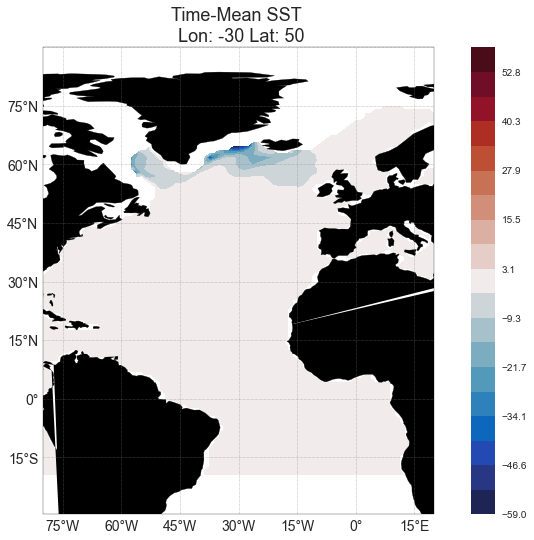

In [132]:
# Quickly Visualize Point (it isnt appearing for some reason...)

cmbal = cmocean.cm.balance
sstmean = np.nanmean(sst,2).T
cint = div_cint(sstmean)

latf=60
lonf=-30

klon,klat = find_latlon(lonf,latf,lonr,latr)

fig1,ax1 = init_map(bbox)


pcm = ax1.contourf(lonr,latr,sstmean,cint,cmap=cmbal)
tar = ax1.plot(lonr[klon],latr[klat],marker="+",markersize=2,label="target",color="black")

ax1.set_title("Time-Mean SST \n %s" % loc_figtitle,fontsize=18)

plt.colorbar(pcm)

Text(0.5, 1.0, 'SST (Mean:-11.41)')

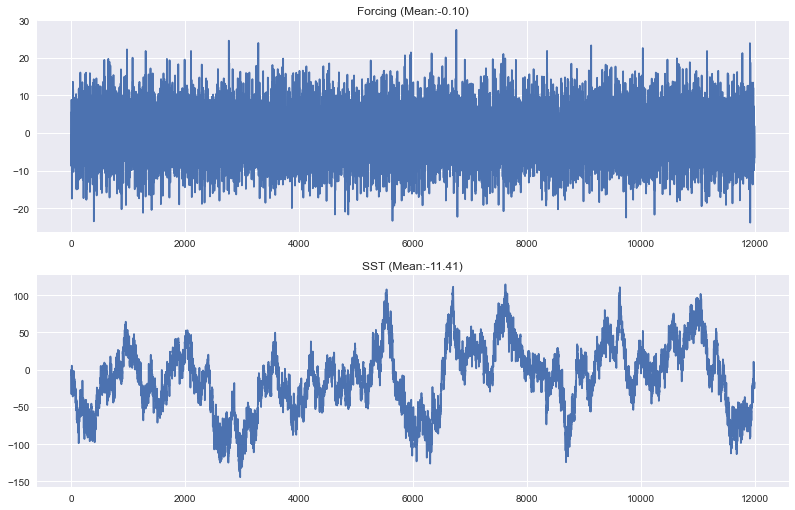

In [135]:
# Plot Timeseries for that point
fts = forcing[klon,klat,:]
sstts = sst[klon,klat,:]

tmean = np.nanmean(sstts)
fmean = np.nanmean(fts)

fig,ax = plt.subplots(2,1,figsize=(12,8))
plt.style.use('seaborn')
plt.subplot(2,1,1)
plt.plot(fts)
plt.title("Forcing (Mean:%.2f)"%(fmean))

plt.subplot(2,1,2)
plt.plot(sstts)
plt.title("SST (Mean:%.2f)"%(tmean))



Closest lon to -30.00 was -30.00
Closest lat to 60.00 was 59.84


Text(0.5, 1.0, 'Seasonal Values for MLD and $\\lambda$ (Ensemble Average) \n Lon: -30 Lat: 60')

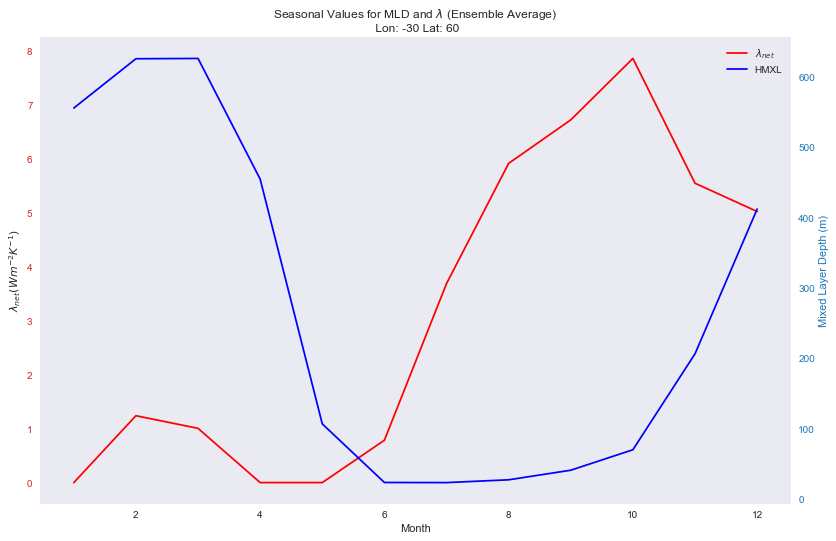

In [142]:
# Plot MLD and Damping For the same term

klon2,klat2 = find_latlon(lonf,latf,lon,lat)



mldpt = mld[klon2,klat2,:]
dampt = damping[klon2,klat2,:]


fig,ax1=plt.subplots(1,1,figsize=(12,8))

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('$\lambda_{net} (W m^{-2} K^{-1}$)')
ln1 = ax1.plot(np.arange(1,13,1),dampt,color='r',label=r'$\lambda_{net}$')
ax1.tick_params(axis='y',labelcolor=color)
ax1.grid(None)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Mixed Layer Depth (m)',color=color)
ln2 = ax2.plot(np.arange(1,13,1),mldpt,color='b',label=r'HMXL')
ax2.tick_params(axis='y',labelcolor=color)
ax2.grid(None)

# Set Legend
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs,loc=0)

# Set Title
titlestr = 'Seasonal Values for MLD and $\lambda$ (Ensemble Average) \n Lon: ' + str(lonf) + ' Lat: '+ str(latf)
plt.title(titlestr)





In [147]:
if((np.any(np.where(lon>180)) & (lonf < 0)) or (np.any(np.where(lon<0)) & (lonf > 180))):
    print("Uh-Oh Mis-match")
else:
    print("You safe.")

You safe.


In [144]:
dampt

array([0.        , 1.24078522, 1.00647616, 0.        , 0.        ,
       0.78604021, 3.69258775, 5.92265439, 6.72940401, 7.86942263,
       5.55403855, 5.02961259])

In [71]:
valmax


0.6940650628405992

In [146]:
45/(1025*3850*50)*(3600*24*30)

0.5911434906556858